In [2]:
! pip install kaggle

In [1]:
! mkdir ~/.kaggle

In [2]:
! cp kaggle.json ~/.kaggle/

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download vipoooool/new-plant-diseases-dataset

100% 2.69G/2.70G [00:39<00:00, 43.9MB/s]
100% 2.70G/2.70G [00:39<00:00, 72.8MB/s]


In [5]:
! unzip new-plant-diseases-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665_270deg.JPG  
  inflating: new plant diseases dataset(augmented)/New 

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#image keras generator
import keras
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# preprocessing function
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions

## EDA

In [7]:
len(os.listdir("/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"))

38

We have 38 classes of images, that is 38 diffent leaf diseases

In [8]:
# load image to data generator(Preprocessing data)
train_datagen = ImageDataGenerator(zoom_range=0.5, shear_range=0.3, 
                                   horizontal_flip=True, preprocessing_function= preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)

In [9]:
# load image
train = train_datagen.flow_from_directory(directory= "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train",
                                          target_size=(256,256),
                                          batch_size= 32)
val = val_datagen.flow_from_directory(directory= "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid",
                                          target_size=(256,256),
                                          batch_size= 32)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


sample image

In [10]:
t_img, label = train.next()

In [11]:
t_img.shape

(32, 256, 256, 3)

Plot the taken 32 images

In [12]:
def plotImage(img_arr, label):
  for im, l in zip(img_arr, label):
    plt.figure(figsize=(5,5))
    plt.imshow(im)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


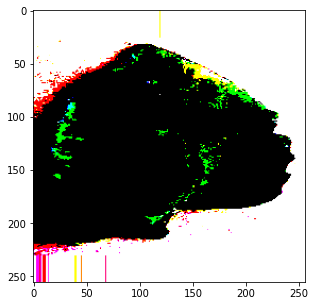

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


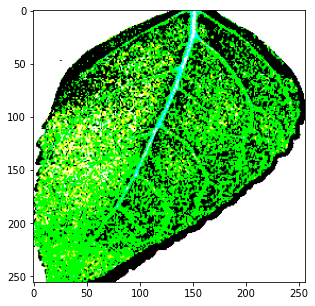

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


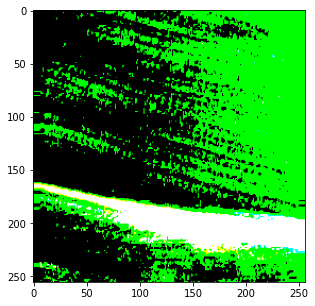

In [13]:
# plot first 5 images
plotImage(t_img[:3], label[:3])

## Create Model

In [14]:
from keras.layers import Dense, Flatten
from keras.models import Model
import keras

In [15]:
# base model
base_model = VGG19(input_shape=(256,256, 3), include_top= False)

80150528/80134624 [==============================] - 1s 0us/step


In [16]:
for layer in base_model.layers:
  layer.trainable = False

In [17]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [18]:
# flatten
X = Flatten()(base_model.output)
X = Dense(units=38, activation='softmax')(X)

## Creating main model
model = Model(base_model.input, X)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

## Early stopping

In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [21]:
# early stopping
es = EarlyStopping(monitor= 'val_accuracy',min_delta=0.01, patience=3, verbose=1)
# model checkpoint
mc = ModelCheckpoint(filepath='best_model.h5',
                     monitor= 'val_accuracy',
                     min_delta= 0.01,
                     patience= 3,
                     verbose= 1,
                     save_best_only= True)
cb = [es, mc]

In [22]:
model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [23]:
his = model.fit_generator(train,
                          steps_per_epoch=16,
                          epochs=50,
                          verbose=1,
                          callbacks=cb,
                          validation_data=val,
                          validation_steps=16)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
16/16 [==============================] - 59s 987ms/step - loss: 29.8993 - accuracy: 0.1855 - val_loss: 17.4828 - val_accuracy: 0.3457

Epoch 00001: val_accuracy improved from -inf to 0.34570, saving model to best_model.h5
Epoch 2/50
16/16 [==============================] - 16s 992ms/step - loss: 17.9364 - accuracy: 0.4023 - val_loss: 11.7562 - val_accuracy: 0.5117

Epoch 00002: val_accuracy improved from 0.34570 to 0.51172, saving model to best_model.h5
Epoch 3/50
16/16 [==============================] - 16s 979ms/step - loss: 12.8257 - accuracy: 0.5000 - val_loss: 9.1156 - val_accuracy: 0.5938

Epoch 00003: val_accuracy improved from 0.51172 to 0.59375, saving model to best_model.h5
Epoch 4/50
16/16 [==============================] - 16s 996ms/step - loss: 9.9238 - accuracy: 0.5840 - val_loss: 8.8321 - val_accuracy: 0.6895

Epoch 00004: val_accuracy improved from 0.59375 to 0.68945, saving model to best_model.h5
Epoch 5/50
16/16 [==============================] - 16s 1s/ste

In [24]:
h = his.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

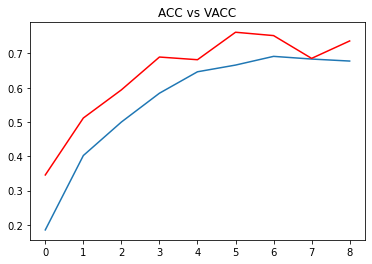

In [25]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c='r')
plt.title('ACC vs VACC')
plt.show()

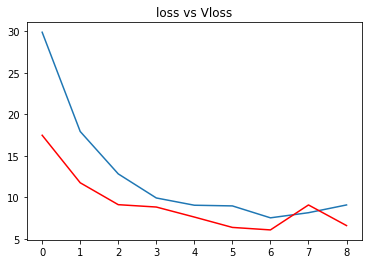

In [26]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c='r')
plt.title('loss vs Vloss')
plt.show()

In [27]:
# load best model

from keras.models import load_model

model = load_model("/content/best_model.h5")

In [28]:
## Evaluate model

acc = model.evaluate_generator(val)[1]

print(f"The accuracy of your model is: {acc*100}%")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


The accuracy of your model is: 73.2073724269867%


In [34]:
ref = dict(zip(list(train.class_indices.values()), list(train.class_indices.keys())))

In [35]:
## Prediction

def prediction(path):
  img = load_img(path, target_size=(256, 256))
  i = img_to_array(img)
  im = preprocess_input(i)
  img = np.expand_dims(im, axis=0)
  pred = np.argmax(model.predict(img))
  print(pred)
  print(f"The image belongs to {ref[pred] }")

In [38]:
path = "/content/test/test/TomatoYellowCurlVirus2.JPG"
prediction(path)

35
The image belongs to Tomato___Tomato_Yellow_Leaf_Curl_Virus
